In [1]:
import pandas as pd
import numpy as np

df=pd.read_csv("battery_life_first_50_cycles.csv")

print(df)

            IR        QC        QD       Tavg       Tmin       Tmax  \
0     0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
1     0.016742  1.071042  1.070689  31.875011  29.566130  35.652016   
2     0.016724  1.071674  1.071900  31.931490  29.604385  35.692978   
3     0.016681  1.072304  1.072510  31.932603  29.744202  35.680588   
4     0.016662  1.072970  1.073174  31.959322  29.644709  35.728691   
...        ...       ...       ...        ...        ...        ...   
6995  0.015602  1.071451  1.071640  32.750094  30.891405  34.619160   
6996  0.015595  1.071707  1.071866  32.754391  30.828009  34.740250   
6997  0.015583  1.071824  1.072039  32.790772  30.861229  34.741764   
6998  0.015592  1.071991  1.072053  32.832211  30.947521  34.724735   
6999  0.015575  1.071953  1.072145  32.863722  31.025038  34.791729   

      chargetime  cycle battery_id   C1    Q1   C2  cycle_life  
0       0.000000    1.0       b1c0  3.6  80.0  3.6      1190.0  
1      13.341250 

In [2]:
cols_to_check = ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime']

Q1 = df[cols_to_check].quantile(0.25)
Q3 = df[cols_to_check].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 2.4 * IQR
upper_bound = Q3 + 2.4 * IQR

mask = ~((df[cols_to_check] < lower_bound) | (df[cols_to_check] > upper_bound)).any(axis=1)
df_cleaned = df[mask]


In [3]:
df_cleaned.shape

(6486, 13)

In [4]:
import pandas as pd

# 1️  Count cycles per battery
battery_counts = df_cleaned['battery_id'].value_counts()

# 2️  Keep only batteries with at least 20 cycles
valid_batteries = battery_counts[battery_counts >= 20].index
df_filtered = df_cleaned[df_cleaned['battery_id'].isin(valid_batteries)]

# 3️ Sort and keep only first 50 cycles per battery
df_50_cycles = (
    df_filtered.sort_values(['battery_id', 'cycle'])
    .groupby('battery_id')
    .head(300)
    .reset_index(drop=True)
)

#  Result summary
print("Final shape:", df_50_cycles.shape)
print("Unique batteries:", df_50_cycles['battery_id'].nunique())

from sklearn.impute import KNNImputer
import pandas as pd

# Define columns to impute
cols_to_impute = ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime','C1','Q1','C2','cycle_life']

# Create imputer instance
imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Fit and transform only those columns, preserving the rest
df_imputed = df_50_cycles.copy()
df_imputed[cols_to_impute] = imputer.fit_transform(df_imputed[cols_to_impute])

# Confirm success
print("Imputation complete. Any NAs remaining?",
      df_imputed[cols_to_impute].isna().any().any())

Final shape: (6470, 13)
Unique batteries: 131
Imputation complete. Any NAs remaining? False


In [5]:
df_50_cycles=df_imputed.copy()

In [6]:
df_imputed.copy()

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,C1,Q1,C2,cycle_life
0,0.016593,1.074618,1.075276,33.438860,30.554556,36.897945,11.734922,2.0,b1c10,5.4,50.0,3.0,906.0
1,0.016551,1.075655,1.076203,33.483851,30.641518,36.926151,11.651227,3.0,b1c10,5.4,50.0,3.0,906.0
2,0.016571,1.076025,1.076798,33.470778,30.650965,36.801983,11.735163,4.0,b1c10,5.4,50.0,3.0,906.0
3,0.016534,1.076603,1.077440,33.530111,30.776867,36.929470,11.734850,5.0,b1c10,5.4,50.0,3.0,906.0
4,0.016492,1.077256,1.077927,33.503897,30.624756,36.870781,11.735015,6.0,b1c10,5.4,50.0,3.0,906.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6465,0.015783,1.072993,1.073291,33.094900,31.306654,35.139908,10.041060,46.0,b3c9,5.3,54.0,4.0,1039.0
6466,0.015766,1.072997,1.073233,33.145761,31.352578,35.165241,10.041038,47.0,b3c9,5.3,54.0,4.0,1039.0
6467,0.015773,1.072968,1.073333,33.184021,31.444122,35.213142,10.041152,48.0,b3c9,5.3,54.0,4.0,1039.0
6468,0.015766,1.072948,1.073181,33.183359,31.407549,35.177643,10.040618,49.0,b3c9,5.3,54.0,4.0,1039.0


In [7]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis

# 0. Start with df_50_cycles: rows = cycles 1–50 for each battery_id
# Aggregation: create per-battery features
from scipy.stats import skew, kurtosis

def aggregate_with_dqv_hist(df, cycle_a=10, cycle_b=100,
                            voltage_grid=np.linspace(2.5, 4.0, 50),
                            bins=5):
    def delta_qv_features(grp):
        a = grp[grp['cycle'] == cycle_a]
        b = grp[grp['cycle'] == cycle_b]
        # ensure both cycles exist
        if a.empty or b.empty:
            return {'dqv_mean': np.nan, 'dqv_var': np.nan,
                    'dqv_skew': np.nan, 'dqv_kurtosis': np.nan}
        qa = np.interp(voltage_grid, a['Q1'], a['QC'])
        qb = np.interp(voltage_grid, b['Q1'], b['QC'])
        dq = qb - qa
        return {
            'dqv_mean': np.nanmean(dq),
            'dqv_var': np.nanvar(dq),
            'dqv_skew': skew(dq),
            'dqv_kurtosis': kurtosis(dq)
        }

    def hist_features(grp, col, bins):
        vals = grp[col].dropna()
        hist, _ = np.histogram(vals, bins=bins, density=True)
        return {f'{col}_hist_{i}': hist[i] for i in range(len(hist))}

    agg_rows = []
    for bid, grp in df.groupby('battery_id'):
        d = {}
        # existing stats & trends
        for col in ['IR', 'QC', 'QD', 'Tavg']:
            vals = grp[col]
            d[f'{col}_mean'] = vals.mean()
            d[f'{col}_std']  = vals.std()
            d[f'{col}_min']  = vals.min()
            d[f'{col}_max']  = vals.max()
            d[f'{col}_skew'] = skew(vals)
            d[f'{col}_kurtosis'] = kurtosis(vals)
            d[f'{col}_trend'] = np.polyfit(grp['cycle'], vals, 1)[0]

        # add ΔQ/ΔV features
        d.update(delta_qv_features(grp))

        # add histograms
        d.update(hist_features(grp, 'IR', bins))
        d.update(hist_features(grp, 'Tavg', bins))

        d['cycle_life'] = grp['cycle_life'].iloc[0]
        agg_rows.append((bid, d))



    agg = pd.DataFrame.from_dict({bid: d for bid, d in agg_rows}, orient='index')
    return agg




agg = aggregate_with_dqv_hist(df_50_cycles)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
# Now your data is per battery: rows = battery_ids

iter_imp = IterativeImputer(random_state=42)

X = agg.drop(columns=['cycle_life'])
X = iter_imp.fit_transform(X)
y = agg['cycle_life']

# ✅ 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ✅ 2. Apply QT separately
qt_X = QuantileTransformer(output_distribution='uniform', random_state=42)
X_train_q = qt_X.fit_transform(X_train)
X_test_q = qt_X.transform(X_test)

qt_y = QuantileTransformer(output_distribution='uniform', random_state=42)
y_train_q = qt_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_q = qt_y.transform(y_test.values.reshape(-1, 1)).flatten()

import joblib

joblib.dump(qt_X, "qt_X_transformer.pkl")
joblib.dump(qt_y, "qt_y_transformer.pkl")

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [28 29 30 31]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(


['qt_y_transformer.pkl']

In [8]:
df_50_cycles=df_imputed.copy()

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis

# 0. Start with df_50_cycles: rows = cycles 1–50 for each battery_id
# Aggregation: create per-battery features
from scipy.stats import skew, kurtosis

def aggregate_with_dqv_hist(df, cycle_a=10, cycle_b=300,
                            voltage_grid=np.linspace(2.5, 4.0, 50),
                            bins=5):
    def delta_qv_features(grp):
        a = grp[grp['cycle'] == cycle_a]
        b = grp[grp['cycle'] == cycle_b]
        # ensure both cycles exist
        if a.empty or b.empty:
            return {'dqv_mean': np.nan, 'dqv_var': np.nan,
                    'dqv_skew': np.nan, 'dqv_kurtosis': np.nan}
        qa = np.interp(voltage_grid, a['Q1'], a['QC'])
        qb = np.interp(voltage_grid, b['Q1'], b['QC'])
        dq = qb - qa
        return {
            'dqv_mean': np.nanmean(dq),
            'dqv_var': np.nanvar(dq),
            'dqv_skew': skew(dq),
            'dqv_kurtosis': kurtosis(dq)
        }

    def hist_features(grp, col, bins):
        vals = grp[col].dropna()
        hist, _ = np.histogram(vals, bins=bins, density=True)
        return {f'{col}_hist_{i}': hist[i] for i in range(len(hist))}

    agg_rows = []
    for bid, grp in df.groupby('battery_id'):
        d = {}
        # existing stats & trends
        for col in ['IR', 'QC', 'QD', 'Tavg']:
            vals = grp[col]
            d[f'{col}_mean'] = vals.mean()
            d[f'{col}_std']  = vals.std()
            d[f'{col}_min']  = vals.min()
            d[f'{col}_max']  = vals.max()
            d[f'{col}_skew'] = skew(vals)
            d[f'{col}_kurtosis'] = kurtosis(vals)
            d[f'{col}_trend'] = np.polyfit(grp['cycle'], vals, 1)[0]

        # add ΔQ/ΔV features
        d.update(delta_qv_features(grp))

        # add histograms
        d.update(hist_features(grp, 'IR', bins))
        d.update(hist_features(grp, 'Tavg', bins))

        d['cycle_life'] = grp['cycle_life'].iloc[0]
        agg_rows.append((bid, d))



    agg = pd.DataFrame.from_dict({bid: d for bid, d in agg_rows}, orient='index')
    return agg




agg = aggregate_with_dqv_hist(df_50_cycles)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
# Now your data is per battery: rows = battery_ids

iter_imp = IterativeImputer(random_state=42)

X = agg.drop(columns=['cycle_life'])
X = iter_imp.fit_transform(X)
y = agg['cycle_life']

# ✅ 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ✅ 2. Apply QT separately
qt_X = QuantileTransformer(output_distribution='uniform', random_state=42)
X_train_q = qt_X.fit_transform(X_train)
X_test_q = qt_X.transform(X_test)

qt_y = QuantileTransformer(output_distribution='uniform', random_state=42)
y_train_q = qt_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_q = qt_y.transform(y_test.values.reshape(-1, 1)).flatten()

import joblib

joblib.dump(qt_X, "qt_X_transformer.pkl")
joblib.dump(qt_y, "qt_y_transformer.pkl")

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [28 29 30 31]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(


['qt_y_transformer.pkl']

In [10]:
pd.DataFrame(X_train_q)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.980583,0.660194,0.970874,0.961165,0.087379,0.203883,0.805825,0.669903,0.873786,0.524272,...,0.135922,0.271845,0.883495,0.883495,0.233010,0.320388,0.300971,0.203883,0.514563,0.446602
1,0.563107,0.873786,0.553398,0.689320,0.766990,0.650485,0.077670,0.786408,0.533981,0.796117,...,0.378641,0.097087,0.087379,0.184466,0.019417,0.300971,0.466019,0.514563,0.504854,0.631068
2,0.514563,0.126214,0.543689,0.475728,0.281553,0.524272,0.893204,0.728155,0.893204,0.737864,...,0.436893,0.990291,0.932039,0.407767,0.339806,0.019417,0.446602,0.368932,0.038835,0.533981
3,0.650485,0.252427,0.669903,0.572816,0.533981,0.669903,0.660194,0.834951,0.029126,0.883495,...,0.029126,0.980583,0.902913,0.572816,0.640777,0.980583,0.029126,0.000000,0.000000,0.000000
4,0.640777,0.961165,0.533981,0.757282,0.359223,0.223301,0.038835,0.262136,0.980583,0.291262,...,0.252427,0.106796,0.184466,0.087379,0.145631,0.087379,0.038835,0.116505,0.252427,0.067961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0.990291,0.592233,1.000000,0.970874,0.543689,0.660194,0.825243,0.679612,0.815534,0.640777,...,0.456311,0.514563,0.504854,0.116505,0.116505,0.271845,0.310680,0.330097,0.922330,0.961165
100,0.000000,0.718447,0.009709,0.000000,0.058252,0.000000,1.000000,0.019417,0.951456,0.048544,...,0.320388,0.262136,0.621359,0.922330,0.970874,0.524272,0.320388,0.582524,0.640777,0.368932
101,0.533981,0.174757,0.572816,0.495146,0.757282,0.834951,0.631068,0.650485,0.310680,0.747573,...,0.601942,0.951456,0.417476,0.368932,0.796117,1.000000,0.951456,0.864078,0.990291,0.922330
102,0.145631,0.262136,0.145631,0.116505,0.436893,0.407767,0.456311,0.320388,0.262136,0.427184,...,0.699029,0.699029,0.864078,0.339806,0.786408,0.116505,0.524272,0.456311,0.524272,0.300971


In [11]:
all_apes=[]

✅ QT + CIR Evaluation:
MAE  : 160.9 cycles
RMSE : 239.1 cycles
R²   : 0.496
APE  : 17.2%


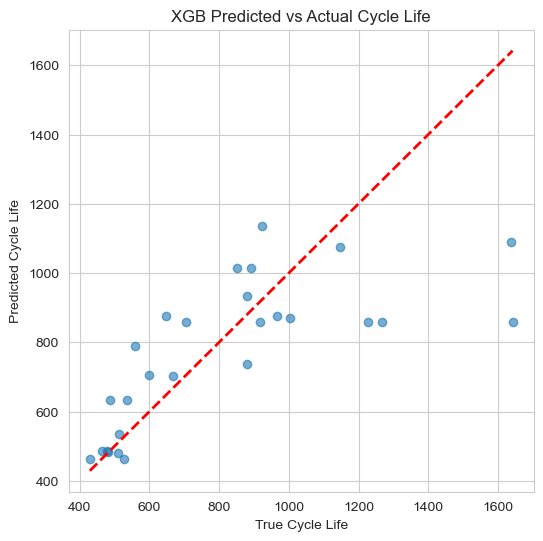

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
import numpy as np

# 1. Base Regression Model (Quantile-Transformed inputs)
modelX = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
modelX.fit(X_train_q, y_train_q)
y_pred_q = modelX.predict(X_test_q)

# 2. Center and apply CIR
y_mean = np.mean(y_train_q)
cir = IsotonicRegression(increasing=True, out_of_bounds='clip')
cir.fit(y_train_q - y_mean, y_train_q)
y_pred_q_cir = cir.predict(y_pred_q - y_mean)

# 3. Inverse-transform back to original scale
y_pred_final = qt_y.inverse_transform(y_pred_q_cir.reshape(-1, 1)).flatten()

# 4. Absolute true values
y_true = y_test.values  # numpy array

# 5. Metrics
mae = mean_absolute_error(y_true, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_final))
r2 = r2_score(y_true, y_pred_final)
XGB_RAW_ape = np.mean(np.abs((y_true - y_pred_final) / y_true)) * 100

print("✅ QT + CIR Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {XGB_RAW_ape:.1f}%")
all_apes.append(f"XGB_300_APE  : {XGB_RAW_ape:.1f}%")

# 6. Visualization: Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_final, alpha=0.6)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("XGB Predicted vs Actual Cycle Life")
plt.grid(True)
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1362
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 38
[LightGBM] [Info] Start training from score 0.500093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


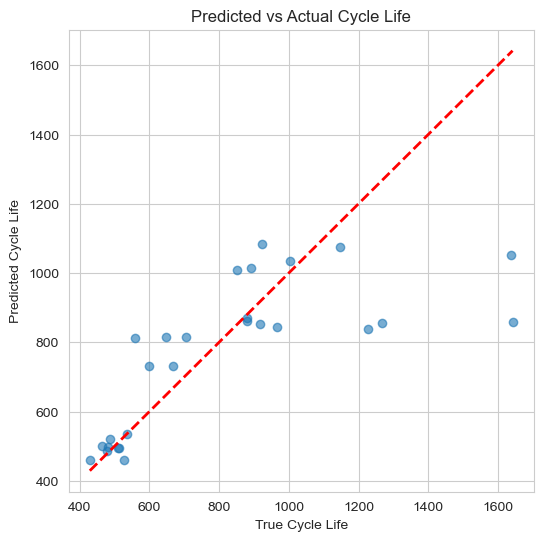

In [13]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

modelL = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
modelL.fit(X_train_q, y_train_q)
y_pred_q = modelL.predict(X_test_q)

# 2. Center and apply CIR
y_mean = np.mean(y_train_q)
cir = IsotonicRegression(increasing=True, out_of_bounds='clip')
cir.fit(y_train_q - y_mean, y_train_q)
y_pred_q_cir = cir.predict(y_pred_q - y_mean)

# 3. Inverse-transform back to original scale
y_pred_final = qt_y.inverse_transform(y_pred_q_cir.reshape(-1, 1)).flatten()

# 4. Absolute true values
y_true = y_test.values  # numpy array
# 5. Metrics
mae = mean_absolute_error(y_true, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_final))
r2 = r2_score(y_true, y_pred_final)
LGBM_RAW_ape = np.mean(np.abs((y_true - y_pred_final) / y_true)) * 100

print("✅ QT + CIR Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {LGBM_RAW_ape:.1f}%")
all_apes.append(f"LGBM_300_APE  : {LGBM_RAW_ape:.1f}%")

# 6. Visualization: Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_final, alpha=0.6)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("Predicted vs Actual Cycle Life")
plt.grid(True)
plt.show()

✅ QT + CIR Evaluation:
MAE  : 212.2 cycles
RMSE : 302.8 cycles
R²   : 0.192
DECISION_TREE_RAW_APE  : 24.3%


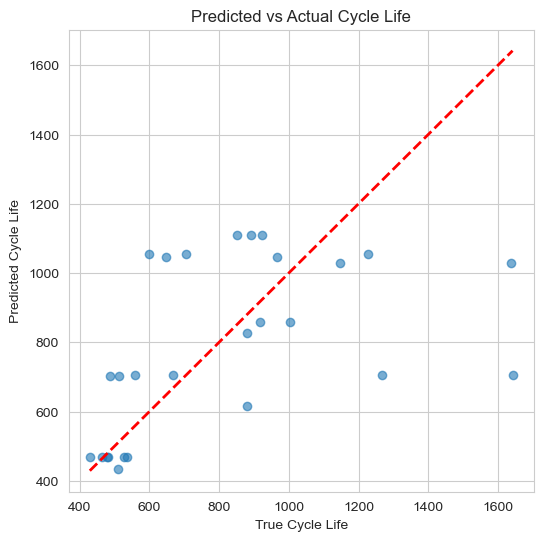

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


# 3. Train DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train_q, y_train_q)
y_pred_q = tree.predict(X_test_q)

# 4. (Optional) Apply CIR for monotonic correction
y_mean = np.mean(y_train_q)
cir = IsotonicRegression(increasing=True, out_of_bounds='clip')
cir.fit(y_train_q - y_mean, y_train_q)
y_pred_q_cir = cir.predict(y_pred_q - y_mean)

# 5. Inverse-transform predictions
# Skip CIR if you don't want it: use y_pred_q directly
y_pred_final = qt_y.inverse_transform(y_pred_q_cir.reshape(-1, 1)).flatten()

# 6. Evaluate performance
mae = mean_absolute_error(y_test, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2 = r2_score(y_test, y_pred_final)
DECISION_TREE_RAW_APE= np.mean(np.abs((y_true - y_pred_final) / y_true)) * 100

print("✅ QT + CIR Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"DECISION_TREE_RAW_APE  : {DECISION_TREE_RAW_APE:.1f}%")
all_apes.append(f"DECISION_TREE_300_APE  : {DECISION_TREE_RAW_APE:.1f}%")

# 6. Visualization: Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_final, alpha=0.6)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("Predicted vs Actual Cycle Life")
plt.grid(True)
plt.show()

🤝 KNN Regression + QT:
MAE  : 138.9 cycles
RMSE : 221.6 cycles
R²   : 0.567
APE  : 14.3%


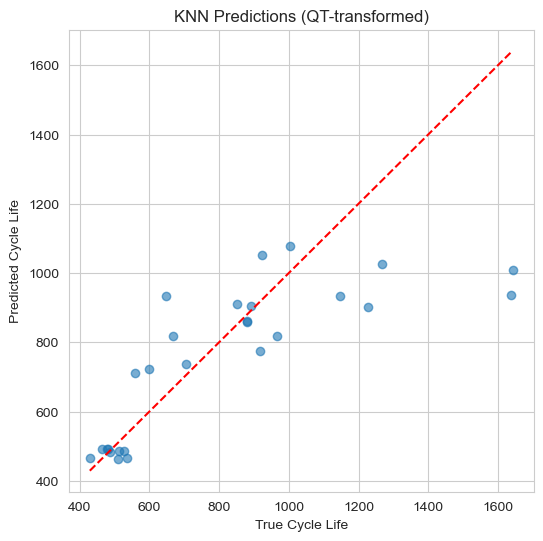

In [15]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Assume X_train_q, X_test_q, y_train, y_test, qt_y defined already

# 1️⃣ Train KNN regressor
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(X_train_q, y_train_q)

# 2️⃣ Prediction
y_pred_q = knn.predict(X_test_q)

# 3️⃣ Inverse-transform predictions
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()

# 4️⃣ Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
KNN_RAW_APE= np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("🤝 KNN Regression + QT:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {KNN_RAW_APE:.1f}%")
all_apes.append(f"KNN_300_APE : {DECISION_TREE_RAW_APE:.1f}%")
# 5️⃣ Visualization
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("KNN Predictions (QT-transformed)")
plt.grid(True)
plt.show()

In [16]:
pd.DataFrame(X_test_q[:200])

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.740822,0.725894,0.773499,0.736615,0.901697,0.889442,0.210771,0.895282,0.748049,0.776112,...,0.497838,0.214226,0.095480,0.000000,0.177507,0.387933,0.364654,0.569966,0.694740,0.463038
1,0.600476,0.264396,0.623398,0.548115,0.345455,0.339770,0.623503,0.977854,0.428929,0.976154,...,0.567679,0.739106,0.953619,0.645784,0.299420,0.845439,0.913883,0.768633,0.565151,0.257069
2,0.469021,0.267502,0.455577,0.416481,0.058651,0.129750,0.855269,0.895185,0.662987,0.862998,...,0.260286,0.451950,1.000000,0.991251,0.971066,0.931237,0.121331,0.021744,0.082956,0.507181
3,0.556308,0.274946,0.594931,0.519705,0.284894,0.302713,0.880163,0.937932,0.141123,0.947836,...,0.412881,0.953743,0.917634,0.883310,0.302990,0.851311,0.970834,0.449436,0.170081,0.059178
4,0.060648,0.441585,0.065562,0.064392,0.655817,0.544229,0.403967,0.089393,0.229694,0.096516,...,0.739805,0.691823,0.516308,0.000000,0.909517,0.611710,0.439449,0.780251,0.909357,0.655870
5,0.805835,0.901248,0.787041,0.851616,0.463732,0.369751,0.066989,0.620829,0.381327,0.633798,...,0.258696,0.187101,0.142733,0.151374,0.132056,0.159525,0.189807,0.298641,0.503147,0.658920
6,0.768982,0.802492,0.779743,0.755966,0.670854,0.551566,0.145636,0.465822,0.729736,0.338982,...,0.454565,0.148380,0.161011,0.049501,0.245169,0.313003,0.221959,0.310651,0.514527,0.742913
7,0.033723,0.486172,0.037281,0.040200,0.907953,0.884808,0.445816,0.115367,0.439809,0.116253,...,0.827498,0.305322,0.308053,0.207458,0.550298,0.523801,0.537965,0.793416,0.827681,0.350001
8,0.941429,0.644026,0.948552,0.867108,0.222331,0.304388,0.981280,0.643830,0.917917,0.462583,...,0.261712,0.486386,0.802921,0.541033,0.101235,0.362897,0.424347,0.293391,0.910098,0.552398
9,0.482095,0.193332,0.490427,0.439835,0.197865,0.127438,0.952587,0.765894,0.148600,0.846107,...,0.575205,0.779389,0.953627,0.973969,0.458699,0.925654,0.680915,0.783928,0.404367,0.061019


In [17]:
agg.columns

Index(['IR_mean', 'IR_std', 'IR_min', 'IR_max', 'IR_skew', 'IR_kurtosis',
       'IR_trend', 'QC_mean', 'QC_std', 'QC_min', 'QC_max', 'QC_skew',
       'QC_kurtosis', 'QC_trend', 'QD_mean', 'QD_std', 'QD_min', 'QD_max',
       'QD_skew', 'QD_kurtosis', 'QD_trend', 'Tavg_mean', 'Tavg_std',
       'Tavg_min', 'Tavg_max', 'Tavg_skew', 'Tavg_kurtosis', 'Tavg_trend',
       'dqv_mean', 'dqv_var', 'dqv_skew', 'dqv_kurtosis', 'IR_hist_0',
       'IR_hist_1', 'IR_hist_2', 'IR_hist_3', 'IR_hist_4', 'Tavg_hist_0',
       'Tavg_hist_1', 'Tavg_hist_2', 'Tavg_hist_3', 'Tavg_hist_4',
       'cycle_life'],
      dtype='object')

In [18]:
pd.DataFrame(X_test_q)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.740822,0.725894,0.773499,0.736615,0.901697,0.889442,0.210771,0.895282,0.748049,0.776112,...,0.497838,0.214226,0.095480,0.000000,0.177507,0.387933,0.364654,0.569966,0.694740,0.463038
1,0.600476,0.264396,0.623398,0.548115,0.345455,0.339770,0.623503,0.977854,0.428929,0.976154,...,0.567679,0.739106,0.953619,0.645784,0.299420,0.845439,0.913883,0.768633,0.565151,0.257069
2,0.469021,0.267502,0.455577,0.416481,0.058651,0.129750,0.855269,0.895185,0.662987,0.862998,...,0.260286,0.451950,1.000000,0.991251,0.971066,0.931237,0.121331,0.021744,0.082956,0.507181
3,0.556308,0.274946,0.594931,0.519705,0.284894,0.302713,0.880163,0.937932,0.141123,0.947836,...,0.412881,0.953743,0.917634,0.883310,0.302990,0.851311,0.970834,0.449436,0.170081,0.059178
4,0.060648,0.441585,0.065562,0.064392,0.655817,0.544229,0.403967,0.089393,0.229694,0.096516,...,0.739805,0.691823,0.516308,0.000000,0.909517,0.611710,0.439449,0.780251,0.909357,0.655870
5,0.805835,0.901248,0.787041,0.851616,0.463732,0.369751,0.066989,0.620829,0.381327,0.633798,...,0.258696,0.187101,0.142733,0.151374,0.132056,0.159525,0.189807,0.298641,0.503147,0.658920
6,0.768982,0.802492,0.779743,0.755966,0.670854,0.551566,0.145636,0.465822,0.729736,0.338982,...,0.454565,0.148380,0.161011,0.049501,0.245169,0.313003,0.221959,0.310651,0.514527,0.742913
7,0.033723,0.486172,0.037281,0.040200,0.907953,0.884808,0.445816,0.115367,0.439809,0.116253,...,0.827498,0.305322,0.308053,0.207458,0.550298,0.523801,0.537965,0.793416,0.827681,0.350001
8,0.941429,0.644026,0.948552,0.867108,0.222331,0.304388,0.981280,0.643830,0.917917,0.462583,...,0.261712,0.486386,0.802921,0.541033,0.101235,0.362897,0.424347,0.293391,0.910098,0.552398
9,0.482095,0.193332,0.490427,0.439835,0.197865,0.127438,0.952587,0.765894,0.148600,0.846107,...,0.575205,0.779389,0.953627,0.973969,0.458699,0.925654,0.680915,0.783928,0.404367,0.061019


In [19]:
import pandas as pd
import numpy as np

# Step 1: Prepare original feature columns
original_cols = agg.drop(columns=['cycle_life']).columns.tolist()

# Step 2: Drop target and apply IterativeImputer
X = agg.drop(columns=['cycle_life'])
X_imputed = iter_imp.fit_transform(X)

# Step 3: Handle dropped columns gracefully
# Only keep columns that did NOT become all-NaN or caused failure in IterativeImputer
retained_col_count = X_imputed.shape[1]

# Step 4: Identify which columns were dropped
retained_cols = original_cols[:retained_col_count]  # safe assumption: IterativeImputer returns in order but drops tailing NaN cols
dropped_cols = list(set(original_cols) - set(retained_cols))

# Step 5: Print
print(f"✅ Retained ({len(retained_cols)}):", retained_cols)
print(f"❌ Dropped ({len(dropped_cols)}):", dropped_cols)

# Step 6: Proceed with retained_cols for further work
X_imputed_df = pd.DataFrame(X_imputed, columns=retained_cols)


✅ Retained (38): ['IR_mean', 'IR_std', 'IR_min', 'IR_max', 'IR_skew', 'IR_kurtosis', 'IR_trend', 'QC_mean', 'QC_std', 'QC_min', 'QC_max', 'QC_skew', 'QC_kurtosis', 'QC_trend', 'QD_mean', 'QD_std', 'QD_min', 'QD_max', 'QD_skew', 'QD_kurtosis', 'QD_trend', 'Tavg_mean', 'Tavg_std', 'Tavg_min', 'Tavg_max', 'Tavg_skew', 'Tavg_kurtosis', 'Tavg_trend', 'dqv_mean', 'dqv_var', 'dqv_skew', 'dqv_kurtosis', 'IR_hist_0', 'IR_hist_1', 'IR_hist_2', 'IR_hist_3', 'IR_hist_4', 'Tavg_hist_0']
❌ Dropped (4): ['Tavg_hist_1', 'Tavg_hist_4', 'Tavg_hist_3', 'Tavg_hist_2']


C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [28 29 30 31]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [22]:
import shap
import pandas as pd

# Final 40 feature names (after dropping the 2 problematic ones)
feature_names = ['IR_mean', 'IR_std', 'IR_min', 'IR_max', 'IR_skew', 'IR_kurtosis', 'IR_trend', 'QC_mean', 'QC_std', 'QC_min', 'QC_max', 'QC_skew', 'QC_kurtosis', 'QC_trend', 'QD_mean', 'QD_std', 'QD_min', 'QD_max', 'QD_skew', 'QD_kurtosis', 'QD_trend', 'Tavg_mean', 'Tavg_std', 'Tavg_min', 'Tavg_max', 'Tavg_skew', 'Tavg_kurtosis', 'Tavg_trend', 'dqv_mean', 'dqv_var', 'dqv_skew', 'dqv_kurtosis', 'IR_hist_0', 'IR_hist_1', 'IR_hist_2', 'IR_hist_3', 'IR_hist_4', 'Tavg_hist_0', 'Tavg_hist_1', 'Tavg_hist_2']

# Prepare DataFrame for SHAP plotting
X_test_df = pd.DataFrame(X_test_q[:200], columns=feature_names)

# Create SHAP explainer
explainer = shap.KernelExplainer(knn.predict, X_train_q)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_q[:200], nsamples=100)

# Summary plot with correct feature names
shap.summary_plot(shap_values, X_test_df)

ValueError: Shape of passed values is (27, 38), indices imply (27, 40)

  0%|          | 0/27 [00:00<?, ?it/s]

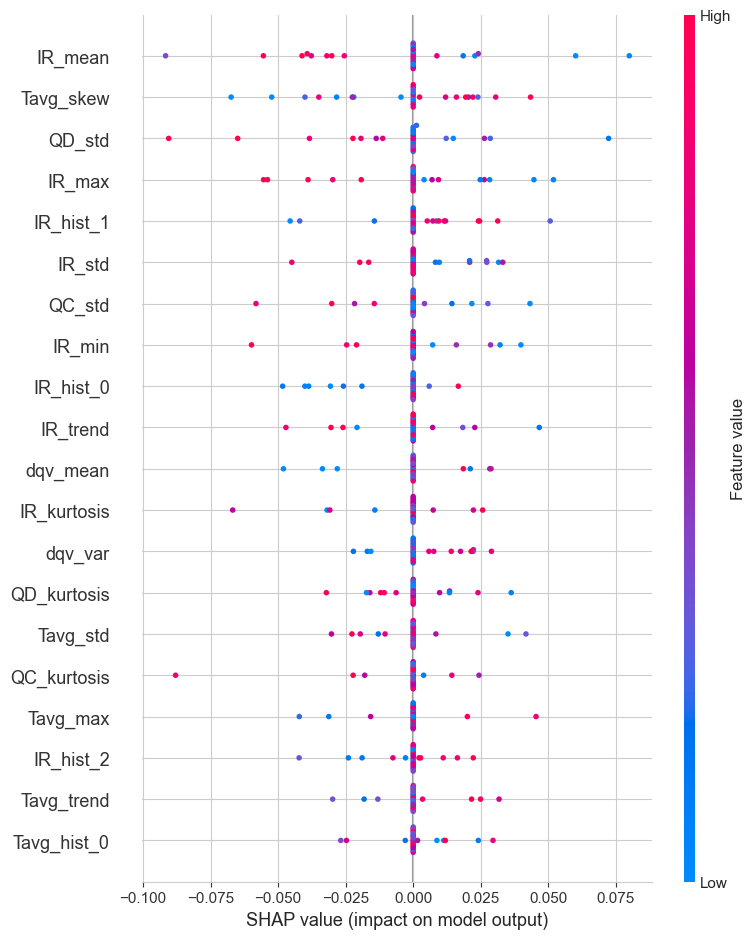

In [23]:
import shap
import pandas as pd

# Updated to match your actual 38-column data
feature_names = [
    'IR_mean', 'IR_std', 'IR_min', 'IR_max', 'IR_skew', 'IR_kurtosis', 'IR_trend',
    'QC_mean', 'QC_std', 'QC_min', 'QC_max', 'QC_skew', 'QC_kurtosis', 'QC_trend',
    'QD_mean', 'QD_std', 'QD_min', 'QD_max', 'QD_skew', 'QD_kurtosis', 'QD_trend',
    'Tavg_mean', 'Tavg_std', 'Tavg_min', 'Tavg_max', 'Tavg_skew', 'Tavg_kurtosis', 'Tavg_trend',
    'dqv_mean', 'dqv_var', 'dqv_skew', 'dqv_kurtosis',
    'IR_hist_0', 'IR_hist_1', 'IR_hist_2',
    'Tavg_hist_0', 'Tavg_hist_1', 'Tavg_hist_2'
]

# Create DataFrame
X_test_df = pd.DataFrame(X_test_q[:200], columns=feature_names)

# Use matching background data for KernelExplainer
X_train_background = X_train_q[:100]  # Should also be 38 columns

# SHAP explainer
explainer = shap.KernelExplainer(lambda x: knn.predict(x).flatten(), X_train_background)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_q[:200], nsamples=100)

# Plot summary
shap.summary_plot(shap_values, X_test_df)


In [24]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

MODEL_PATH = "best_model.keras"

# 1. If model exists, load it
if os.path.exists(MODEL_PATH):
    print(f"🔁 Loading existing model from {MODEL_PATH}")
    model = load_model(MODEL_PATH)
else:
    print("🛠️ Building new model...")
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(1e-5), input_shape=(X_train_q.shape[1],)),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=l2(1e-5)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

# 2. Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

model_ckpt = ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # Saves full model
    verbose=1
)

# 3. Train model
history = model.fit(
    X_train_q, y_train_q,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, reduce_lr, model_ckpt],
    verbose=1
)

🔁 Loading existing model from best_model.keras
Epoch 1/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 2s 558ms/step - loss: 0.0424
Epoch 1: val_loss improved from inf to 0.03103, saving model to best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0448 - val_loss: 0.0310 - learning_rate: 5.0000e-04
Epoch 2/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0389
Epoch 2: val_loss improved from 0.03103 to 0.03057, saving model to best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0465 - val_loss: 0.0306 - learning_rate: 5.0000e-04
Epoch 3/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0529
Epoch 3: val_loss improved from 0.03057 to 0.03001, saving model to best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0440 - val_loss: 0.0300 - learning_rate: 5.0000e-04
Epoch 4/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0144
Epoch 4: val_loss did not improve from 0.03001
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0354 - val_loss: 0.0310 - learning_rate: 5.000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
✅ QT + CIR Evaluation:
MAE  : 0.1 cycles
RMSE : 0.1 cycles
R²   : 0.217
APE  : 18.4%


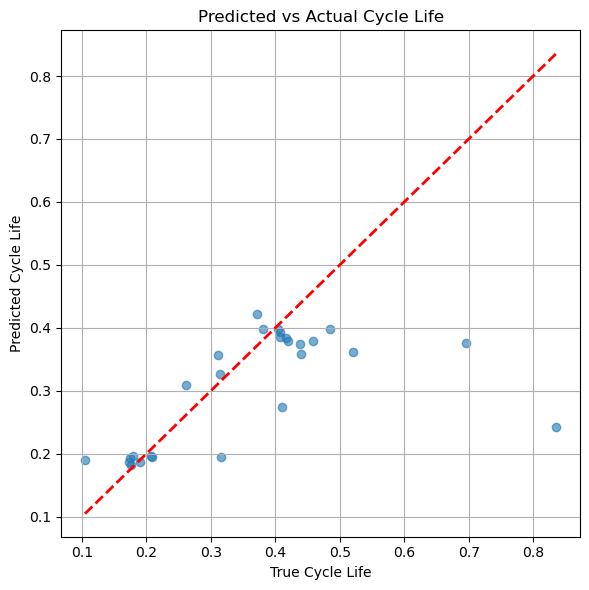

In [25]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1️⃣ Load saved model
model = load_model("best_model.keras")

# 2️⃣ Predict
y_pred_q = model.predict(X_test_q).flatten()

# 3️⃣ Inverse transform if target was scaled
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()

# 4️⃣ True values (inverse transform if needed)
y_true = y_test  # or: qt_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 5️⃣ Evaluation
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
DL_RAW_APE= np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("✅ QT + CIR Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {DL_RAW_APE:.1f}%")
all_apes.append(f"DL_300_APE : {DL_RAW_APE:.1f}%")
# 6️⃣ Visualization
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("Predicted vs Actual Cycle Life")
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ------------------------
# Set Global Seed Once
# ------------------------


# ------------------------
# Define Model Architecture
# ------------------------
def build_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(256, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu', name='embedding_layer')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# ------------------------
# Paths
# ------------------------
model_weights_path = "best_dl.weights.h5"
val_loss_record_path = "best_val_loss.txt"

# ------------------------
# Normalize y_train_q
# ------------------------
y_mean = y_train_q.mean()
y_std = y_train_q.std()
y_train_scaled = (y_train_q - y_mean) / y_std

# ------------------------
# Initial Setup
# ------------------------
first_time = not os.path.exists(model_weights_path)

if os.path.exists(val_loss_record_path):
    with open(val_loss_record_path, "r") as f:
        best_val_loss = float(f.read().strip())
else:
    best_val_loss = float('inf')

# ------------------------
# Train Loop with EarlyStopping
# ------------------------
count = 0
for i in range(100):
    np.random.seed(i)
    tf.random.set_seed(i)
    if count >= 10:
        break

    print(f"\n🌀 Run {i+1}")

    # Build model
    base_model = build_model(X_train_q.shape[1])

    # Load previous weights if available
    if not first_time and os.path.exists(model_weights_path):
        print("📥 Loading existing weights...")
        base_model.load_weights(model_weights_path)

    # Train model
    history = base_model.fit(
        X_train_q, y_train_scaled,
        validation_split=0.2,
        epochs=100,
        batch_size=16,
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
        ],
        verbose=0
    )

    # Get best val loss this run
    run_best_val_loss = min(history.history['val_loss'])
    print(f"📉 Best val loss this run: {run_best_val_loss:.6f}")

    # Save first model no matter what
    if first_time:
        print(f"💾 Saving initial weights with val_loss: {run_best_val_loss:.6f}")
        base_model.save_weights(model_weights_path)
        with open(val_loss_record_path, "w") as f:
            f.write(str(run_best_val_loss))
        best_val_loss = run_best_val_loss
        first_time = False
        count = 0
    elif run_best_val_loss < best_val_loss - 1e-6:
        print(f"✅ Improved: {best_val_loss:.6f} → {run_best_val_loss:.6f} — saving weights.")
        base_model.save_weights(model_weights_path)
        with open(val_loss_record_path, "w") as f:
            f.write(str(run_best_val_loss))
        best_val_loss = run_best_val_loss
        count = 0
    else:
        print("⏩ No improvement. Count increased.")
        count += 1

# ------------------------
# Load Best Model & Extract Embeddings
# ------------------------
base_model = build_model(X_train_q.shape[1])
base_model.load_weights(model_weights_path)

embed_model = Model(
    inputs=base_model.input,
    outputs=base_model.get_layer('embedding_layer').output
)
X_train_embed = embed_model.predict(X_train_q)
X_test_embed = embed_model.predict(X_test_q)

# Optional: Predict and unscale
y_pred_scaled = base_model.predict(X_test_q)
y_pred = y_pred_scaled * y_std + y_mean


🌀 Run 1
📥 Loading existing weights...


C:\Users\ROHIT\miniconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
📉 Best val loss this run: 0.184288
⏩ No improvement. Count increased.

🌀 Run 2
📥 Loading existing weights...

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
📉 Best val loss this run: 0.196910
⏩ No improvement. Count increased.

🌀 Run 3
📥 Loading existing weights...

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
📉 Best val loss this run: 0.205437
⏩ No improvement. Count increa

🤝KNN + DL:
MAE  : 127.7 cycles
RMSE : 214.7 cycles
R²   : 0.594
APE  : 13.7%


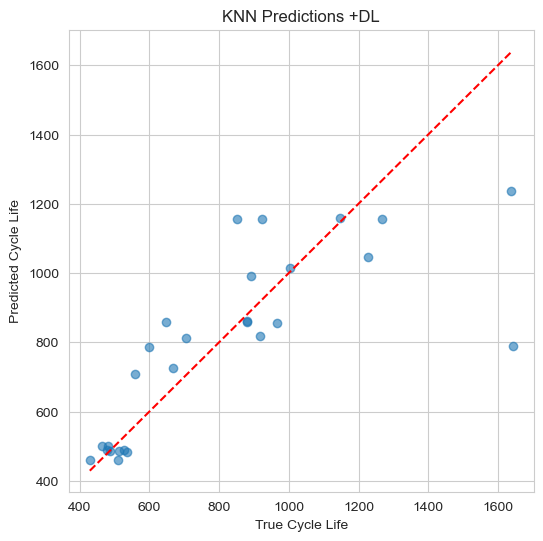

In [26]:
# Step 4: Train KNN on these embeddings
knnDL = KNeighborsRegressor(n_neighbors=3)
knnDL.fit(X_train_embed, y_train_q)
y_pred_q = knnDL.predict(X_test_embed)

# Step 5: Inverse transform and evaluate
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
KNN__DL_RAW_APE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("🤝KNN + DL:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {KNN__DL_RAW_APE:.1f}%")
all_apes.append(f"KNN__DL_300_APE : {KNN__DL_RAW_APE:.1f}%")
# 5️⃣ Visualization
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("KNN Predictions +DL")
plt.grid(True)
plt.show()

XGB +DL
MAE  : 158.1 cycles
RMSE : 257.4 cycles
R²   : 0.416
APE  : 17.5%


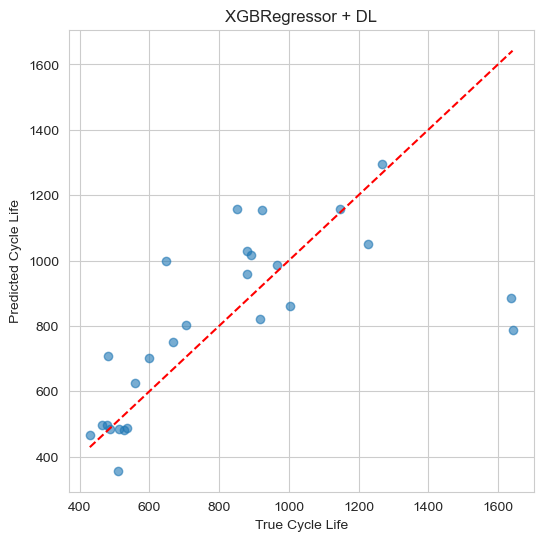

In [27]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 4: Train XGBoost on DL embeddings
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

X_train_combined = np.concatenate([X_train_q, X_train_embed], axis=1)
X_test_combined = np.concatenate([X_test_q, X_test_embed], axis=1)

xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
xgb.fit(X_train_combined, y_train_q)

y_pred_q = xgb.predict(X_test_combined)
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()


# Step 6: Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
XGB__DL_RAW_APE= np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("XGB +DL")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {XGB__DL_RAW_APE:.1f}%")
all_apes.append(f"XGB__DL_300_APE : {XGB__DL_RAW_APE:.1f}%")
# 5️⃣ Visualization
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("XGBRegressor + DL")
plt.grid(True)
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2399
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 88
[LightGBM] [Info] Start training from score 0.500093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


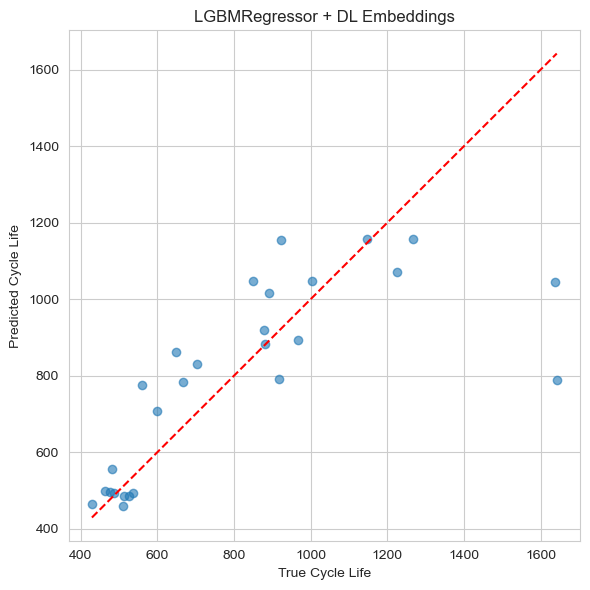

In [28]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Combine features: handcrafted + DL embeddings
X_train_combined = np.concatenate([X_train_q, X_train_embed], axis=1)
X_test_combined = np.concatenate([X_test_q, X_test_embed], axis=1)

# Initialize and train LGBM model
lgbm = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    objective='regression'
)
lgbm.fit(X_train_combined, y_train_q)

# Predict and inverse-transform
y_pred_q = lgbm.predict(X_test_combined)
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
LGBM__DL_RAW_APE= np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("📊 LGBM + DL Evaluation")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {LGBM__DL_RAW_APE:.1f}%")
all_apes.append(f"LGBM__DL_300_APE : {LGBM__DL_RAW_APE:.1f}%")
# Plot: Predicted vs True
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("LGBMRegressor + DL Embeddings")
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
df_new= (
    df_filtered.sort_values(['battery_id', 'cycle'])
    .groupby('battery_id')
    .head(100)
    .reset_index(drop=True)
)
df_new

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,C1,Q1,C2,cycle_life
0,0.016593,1.074618,1.075276,33.438860,30.554556,36.897945,11.734922,2.0,b1c10,5.4,50.0,3.0,906.0
1,0.016551,1.075655,1.076203,33.483851,30.641518,36.926151,11.651227,3.0,b1c10,5.4,50.0,3.0,906.0
2,0.016571,1.076025,1.076798,33.470778,30.650965,36.801983,11.735163,4.0,b1c10,5.4,50.0,3.0,906.0
3,0.016534,1.076603,1.077440,33.530111,30.776867,36.929470,11.734850,5.0,b1c10,5.4,50.0,3.0,906.0
4,0.016492,1.077256,1.077927,33.503897,30.624756,36.870781,11.735015,6.0,b1c10,5.4,50.0,3.0,906.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6465,0.015783,1.072993,1.073291,33.094900,31.306654,35.139908,10.041060,46.0,b3c9,5.3,54.0,4.0,1039.0
6466,0.015766,1.072997,1.073233,33.145761,31.352578,35.165241,10.041038,47.0,b3c9,5.3,54.0,4.0,1039.0
6467,0.015773,1.072968,1.073333,33.184021,31.444122,35.213142,10.041152,48.0,b3c9,5.3,54.0,4.0,1039.0
6468,0.015766,1.072948,1.073181,33.183359,31.407549,35.177643,10.040618,49.0,b3c9,5.3,54.0,4.0,1039.0


In [31]:
import pandas as pd

# 1️⃣ Count cycles per battery
battery_counts = df_cleaned['battery_id'].value_counts()

# 2️⃣ Keep only batteries with at least 50 cycles
valid_batteries = battery_counts[battery_counts >= 20].index
df_filtered = df_cleaned[df_cleaned['battery_id'].isin(valid_batteries)]

# 3️⃣ Sort and keep only first 50 cycles per battery
df_20_cycles = (
    df_filtered.sort_values(['battery_id', 'cycle'])
    .groupby('battery_id')
    .head(10)
    .reset_index(drop=True)
)

# ✅ Result summary
print("Final shape:", df_20_cycles.shape)
print("Unique batteries:", df_20_cycles['battery_id'].nunique())

from sklearn.impute import KNNImputer
import pandas as pd

# Define columns to impute
cols_to_impute = ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime','C1','Q1','C2','cycle_life']

# Create imputer instance
imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Fit and transform only those columns, preserving the rest
df_imputed = df_20_cycles.copy()
df_imputed[cols_to_impute] = imputer.fit_transform(df_imputed[cols_to_impute])

# Confirm success
print("✅ Imputation complete. Any NAs remaining?",
      df_imputed[cols_to_impute].isna().any().any())

df_imputed.shape

Final shape: (1310, 13)
Unique batteries: 131
✅ Imputation complete. Any NAs remaining? False


(1310, 13)

In [32]:
df_imputed

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,C1,Q1,C2,cycle_life
0,0.016593,1.074618,1.075276,33.438860,30.554556,36.897945,11.734922,2.0,b1c10,5.4,50.0,3.0,906.0
1,0.016551,1.075655,1.076203,33.483851,30.641518,36.926151,11.651227,3.0,b1c10,5.4,50.0,3.0,906.0
2,0.016571,1.076025,1.076798,33.470778,30.650965,36.801983,11.735163,4.0,b1c10,5.4,50.0,3.0,906.0
3,0.016534,1.076603,1.077440,33.530111,30.776867,36.929470,11.734850,5.0,b1c10,5.4,50.0,3.0,906.0
4,0.016492,1.077256,1.077927,33.503897,30.624756,36.870781,11.735015,6.0,b1c10,5.4,50.0,3.0,906.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0.015835,1.071374,1.071818,32.920178,31.107897,34.908264,10.041880,6.0,b3c9,5.3,54.0,4.0,1039.0
1306,0.015815,1.071851,1.072151,32.961129,31.108976,34.894360,10.041747,7.0,b3c9,5.3,54.0,4.0,1039.0
1307,0.015808,1.072034,1.072294,32.985488,31.201126,34.951191,10.041432,8.0,b3c9,5.3,54.0,4.0,1039.0
1308,0.015802,1.072273,1.072488,33.024481,31.251135,34.879253,10.040825,9.0,b3c9,5.3,54.0,4.0,1039.0


In [33]:
df_10_cycles=df_imputed.copy()

In [34]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis

# 0. Start with df_50_cycles: rows = cycles 1–50 for each battery_id
# Aggregation: create per-battery features
from scipy.stats import skew, kurtosis

def aggregate_with_dqv_hist(df, cycle_a=1, cycle_b=10,
                            voltage_grid=np.linspace(2.5, 4.0, 50),
                            bins=5):
    def delta_qv_features(grp):
        a = grp[grp['cycle'] == cycle_a]
        b = grp[grp['cycle'] == cycle_b]
        # ensure both cycles exist
        if a.empty or b.empty:
            return {'dqv_mean': np.nan, 'dqv_var': np.nan,
                    'dqv_skew': np.nan, 'dqv_kurtosis': np.nan}
        qa = np.interp(voltage_grid, a['Q1'], a['QC'])
        qb = np.interp(voltage_grid, b['Q1'], b['QC'])
        dq = qb - qa
        return {
            'dqv_mean': np.nanmean(dq),
            'dqv_var': np.nanvar(dq),
            'dqv_skew': skew(dq),
            'dqv_kurtosis': kurtosis(dq)
        }

    def hist_features(grp, col, bins):
        vals = grp[col].dropna()
        hist, _ = np.histogram(vals, bins=bins, density=True)
        return {f'{col}_hist_{i}': hist[i] for i in range(len(hist))}

    agg_rows = []
    for bid, grp in df.groupby('battery_id'):
        d = {}
        # existing stats & trends
        for col in ['IR', 'QC', 'QD', 'Tavg']:
            vals = grp[col]
            d[f'{col}_mean'] = vals.mean()
            d[f'{col}_std']  = vals.std()
            d[f'{col}_min']  = vals.min()
            d[f'{col}_max']  = vals.max()
            d[f'{col}_skew'] = skew(vals)
            d[f'{col}_kurtosis'] = kurtosis(vals)
            d[f'{col}_trend'] = np.polyfit(grp['cycle'], vals, 1)[0]

        # add ΔQ/ΔV features
        d.update(delta_qv_features(grp))

        # add histograms
        d.update(hist_features(grp, 'IR', bins))
        d.update(hist_features(grp, 'Tavg', bins))

        d['cycle_life'] = grp['cycle_life'].iloc[0]
        agg_rows.append((bid, d))



    agg = pd.DataFrame.from_dict({bid: d for bid, d in agg_rows}, orient='index')
    return agg




agg = aggregate_with_dqv_hist(df_10_cycles)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
# Now your data is per battery: rows = battery_ids

iter_imp = IterativeImputer(random_state=42)

X = agg.drop(columns=['cycle_life'])
X = iter_imp.fit_transform(X)
y = agg['cycle_life']

# ✅ 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ✅ 2. Apply QT separately
qt_X_20 = QuantileTransformer(output_distribution='uniform', random_state=42)
X_train_q_20 = qt_X_20.fit_transform(X_train)
X_test_q_20 = qt_X_20.transform(X_test)

qt_y_20 = QuantileTransformer(output_distribution='uniform', random_state=42)
y_train_q_20 = qt_y_20.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_q_20= qt_y_20.transform(y_test.values.reshape(-1, 1)).flatten()

import joblib

joblib.dump(qt_X_20, "qt_X_20transformer.pkl")
joblib.dump(qt_y_20, "qt_y_20transformer.pkl")

C:\Users\ROHIT\AppData\Local\Temp\ipykernel_8188\34704396.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'dqv_skew': skew(dq),
C:\Users\ROHIT\AppData\Local\Temp\ipykernel_8188\34704396.py:31: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'dqv_kurtosis': kurtosis(dq)
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [30 31]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\ROHIT\minicon

['qt_y_20transformer.pkl']

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 39
[LightGBM] [Info] Start training from score 0.500093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


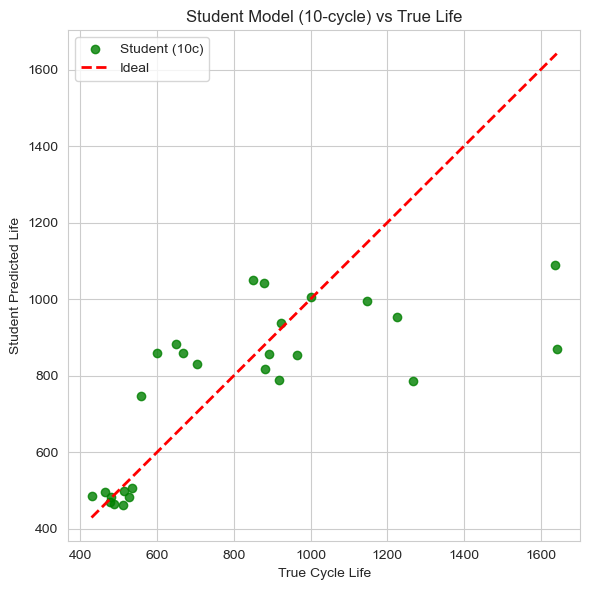

In [35]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import QuantileTransformer
import matplotlib.pyplot as plt
import numpy as np




# Predict true 300-cycle labels
y_pred_teacher_q = modelL.predict(X_test_q)

# Optional: Calibration using CIR
y_mean = np.mean(y_train_q)
cir = IsotonicRegression(increasing=True, out_of_bounds='clip')
cir.fit(y_train_q - y_mean, y_train_q)
y_pred_teacher_q_cir = cir.predict(y_pred_teacher_q - y_mean)

# Inverse transform
y_pred_teacher = qt_y.inverse_transform(y_pred_teacher_q_cir.reshape(-1, 1)).flatten()

# ---------------------
# STEP 3 — STUDENT MODEL (20-cycle mimic)
# ---------------------

# Step 3.1 — Use teacher to generate pseudo-labels on original data
pseudo_labels_train = modelL.predict(X_train_q)
pseudo_labels_test = modelL.predict(X_test_q)

# Train student on 20-cycle features to match teacher outputs
student = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
student.fit(X_train_q_20, pseudo_labels_train)

# Predict using student
student_pred_q = student.predict(X_test_q_20)

# Optionally pass through CIR
student_pred_q_cir = cir.predict(student_pred_q - y_mean)
student_pred_final = qt_y.inverse_transform(student_pred_q_cir.reshape(-1, 1)).flatten()

# ---------------------
# STEP 4 — Evaluation
# ---------------------
y_true = y_test.values

mae = mean_absolute_error(y_true, student_pred_final)
rmse = np.sqrt(mean_squared_error(y_true, student_pred_final))
r2 = r2_score(y_true, student_pred_final)
LGBM_TEACHER_STUDENT_APE= np.mean(np.abs((y_true - student_pred_final) / y_true)) * 100

print("\n📘 Student (10-cycle) Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {LGBM_TEACHER_STUDENT_APE:.1f}%")
all_apes.append(f"LGBM_TEACHER_STUDENT_10_APE: {LGBM_TEACHER_STUDENT_APE:.1f}%")
# ---------------------
# STEP 5 — Plot
# ---------------------
plt.figure(figsize=(6, 6))
plt.scatter(y_true, student_pred_final, alpha=0.8, label='Student (10c)',color="green")
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2, label='Ideal')
plt.xlabel("True Cycle Life")
plt.ylabel("Student Predicted Life")
plt.legend()
plt.title("Student Model (10-cycle) vs True Life")
plt.grid(True)
plt.tight_layout()
plt.show()


📘 Student (KNN) Evaluation:
MAE  : 128.7 cycles
RMSE : 188.7 cycles
R²   : 0.686
APE  : 14.4%

📘 Student (XGB) Evaluation:
MAE  : 158.8 cycles
RMSE : 245.9 cycles
R²   : 0.467
APE  : 16.6%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 39
[LightGBM] [Info] Start training from score 0.494274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


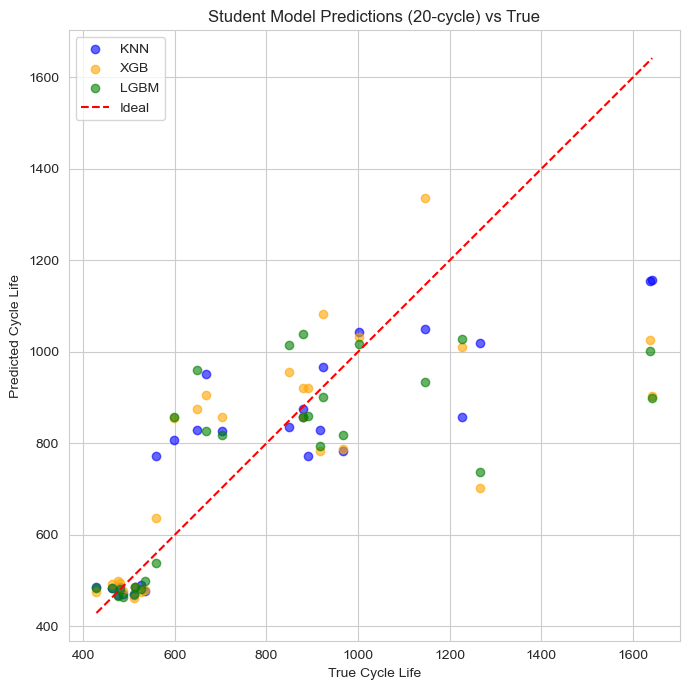


📊 Summary APEs:
XGB_300_APE  : 17.2%
LGBM_300_APE  : 14.7%
DECISION_TREE_300_APE  : 24.3%
KNN_300_APE : 24.3%
KNN__DL_300_APE : 13.7%
XGB__DL_300_APE : 17.5%
LGBM__DL_300_APE : 14.7%
LGBM_TEACHER_STUDENT_10_APE: 16.6%
KNN_DL_TEACHER_AND_STUDENTKNN_10_APE : 14.4%
KNN_DL_TEACHER_AND_STUDENTXGB_10_APE : 16.6%
KNN_DL_TEACHER_AND_STUDENTLGBM_10_APE : 15.7%


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import QuantileTransformer
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# ---- Assumed pre-loaded: ----
# X_train_embed, X_test_embed: embedding features (e.g., from DL encoder)
# X_train_q_20, X_test_q_20   : 20-cycle features (quantile transformed)
# y_train_q                   : Quantile transformed full-cycle life
# y_test                      : Original test labels (true cycle life)
# qt_y                        : Fitted QuantileTransformer on full-cycle labels

# ---- Teacher (KNN + DL) ----
knnDL = KNeighborsRegressor(n_neighbors=3)
knnDL.fit(X_train_embed, y_train_q)

# Teacher predictions
y_pred_teacher_q = knnDL.predict(X_test_embed)
y_mean = np.mean(y_train_q)

# CIR calibration
cir = IsotonicRegression(increasing=True, out_of_bounds='clip')
cir.fit(y_train_q - y_mean, y_train_q)
y_pred_teacher_q_cir = cir.predict(y_pred_teacher_q - y_mean)
y_pred_teacher = qt_y.inverse_transform(y_pred_teacher_q_cir.reshape(-1, 1)).flatten()

# ---- Generate pseudo-labels ----
pseudo_labels_train = knnDL.predict(X_train_embed)
pseudo_labels_test  = knnDL.predict(X_test_embed)

# ---- Students ----
student_models = {
    "KNN": KNeighborsRegressor(n_neighbors=3),
    "XGB": XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42),
    "LGBM": LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
}

student_preds = {}
y_true = y_test.values


def evaluate_student(pred_final, name):
    mae = mean_absolute_error(y_true, pred_final)
    rmse = np.sqrt(mean_squared_error(y_true, pred_final))
    r2 = r2_score(y_true, pred_final)
    ape = np.mean(np.abs((y_true - pred_final) / y_true)) * 100
    print(f"\n📘 Student ({name}) Evaluation:")
    print(f"MAE  : {mae:.1f} cycles")
    print(f"RMSE : {rmse:.1f} cycles")
    print(f"R²   : {r2:.3f}")
    print(f"APE  : {ape:.1f}%")
    all_apes.append(f"KNN_DL_TEACHER_AND_STUDENT{name}_10_APE : {ape:.1f}%")
    return pred_final

# Train and predict all students
for name, model in student_models.items():
    model.fit(X_train_q_20, pseudo_labels_train)
    student_pred_q = model.predict(X_test_q_20)
    student_pred_q_cir = cir.predict(student_pred_q - y_mean)
    pred_final = qt_y.inverse_transform(student_pred_q_cir.reshape(-1, 1)).flatten()
    student_preds[name] = evaluate_student(pred_final, name)

# ---- Plot all students ----
plt.figure(figsize=(7, 7))
colors = {"KNN": "blue", "XGB": "orange", "LGBM": "green"}

for name, preds in student_preds.items():
    plt.scatter(y_true, preds, alpha=0.6, label=f'{name}', color=colors[name])

plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Ideal')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("Student Model Predictions (20-cycle) vs True")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary APEs
print("\n📊 Summary APEs:")
for ape in all_apes:
    print(ape)

In [37]:
df_cleaned

,IR,QC,QD,Tavg,Tmin,Tmax,chargetime,cycle,battery_id,C1,Q1,C2,cycle_life
151,0.016370,1.079315,1.079723,30.245592,29.596653,30.935932,12.008575,2.0,b1c3,4.0,80.0,4.0,1226.0
152,0.016316,1.080695,1.081228,30.313372,29.836266,31.184330,12.008095,3.0,b1c3,4.0,80.0,4.0,1226.0
153,0.016325,1.081566,1.081994,30.278313,29.724728,30.779972,12.008375,4.0,b1c3,4.0,80.0,4.0,1226.0
154,0.016325,1.082248,1.082731,30.393412,29.996559,31.101156,12.008217,5.0,b1c3,4.0,80.0,4.0,1226.0
155,0.016292,1.082696,1.083112,30.331701,29.657597,30.721308,12.092437,6.0,b1c3,4.0,80.0,4.0,1226.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.015602,1.071451,1.071640,32.750094,30.891405,34.619160,11.036730,46.0,b3c45,4.8,80.0,4.8,1801.0
6996,0.015595,1.071707,1.071866,32.754391,30.828009,34.740250,11.036633,47.0,b3c45,4.8,80.0,4.8,1801.0
6997,0.015583,1.071824,1.072039,32.790772,30.861229,34.741764,11.036873,48.0,b3c45,4.8,80.0,4.8,1801.0
6998,0.015592,1.071991,1.072053,32.832211,30.947521,34.724735,11.037575,49.0,b3c45,4.8,80.0,4.8,1801.0


Final shape: (1310, 13)
Unique batteries: 131
✅ Imputation complete. Any NAs remaining? False


C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [28 29 30 31]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(


✅ QT + CIR Evaluation:
MAE  : 179.0 cycles
RMSE : 246.5 cycles
R²   : 0.465
APE  : 20.3%


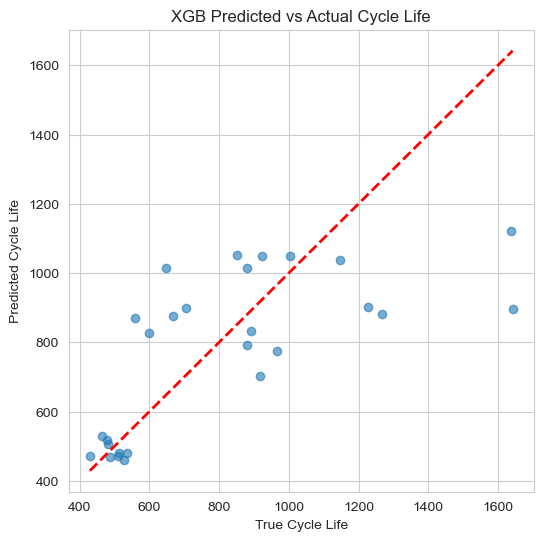

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1341
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 38
[LightGBM] [Info] Start training from score 0.500187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


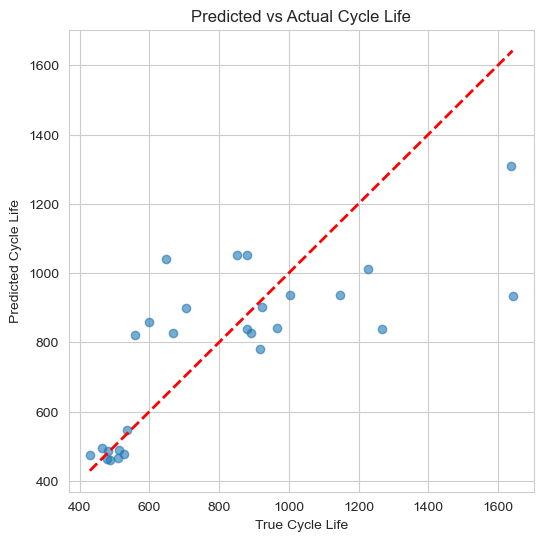

✅ QT + CIR Evaluation:
MAE  : 236.8 cycles
RMSE : 333.3 cycles
R²   : 0.021
DECISION_TREE_RAW_APE  : 28.1%


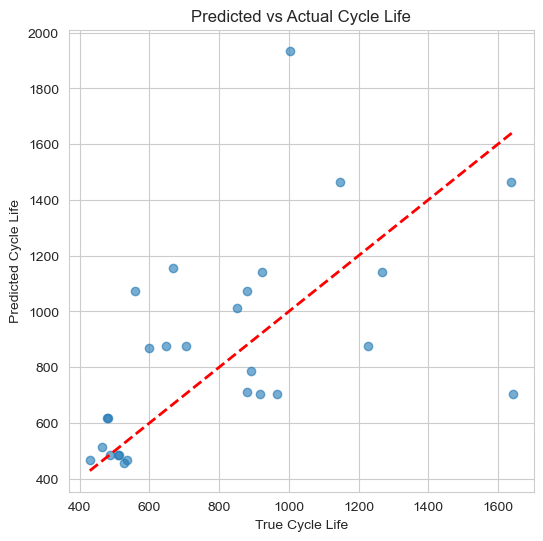

🤝 KNN Regression + QT:
MAE  : 137.3 cycles
RMSE : 211.3 cycles
R²   : 0.606
APE  : 14.8%


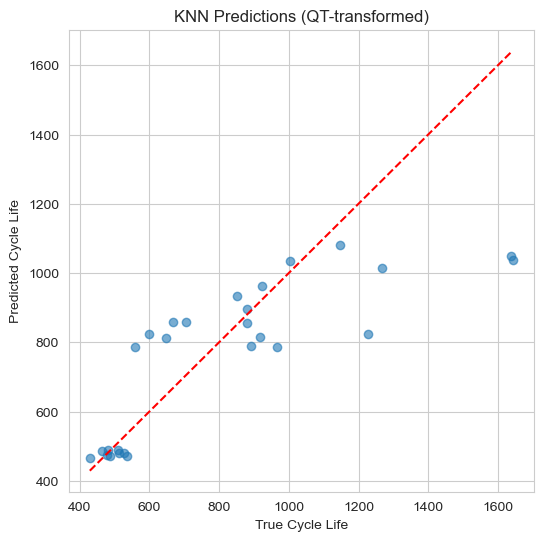

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: [28 29 30 31]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


✅ Retained (38): ['IR_mean', 'IR_std', 'IR_min', 'IR_max', 'IR_skew', 'IR_kurtosis', 'IR_trend', 'QC_mean', 'QC_std', 'QC_min', 'QC_max', 'QC_skew', 'QC_kurtosis', 'QC_trend', 'QD_mean', 'QD_std', 'QD_min', 'QD_max', 'QD_skew', 'QD_kurtosis', 'QD_trend', 'Tavg_mean', 'Tavg_std', 'Tavg_min', 'Tavg_max', 'Tavg_skew', 'Tavg_kurtosis', 'Tavg_trend', 'dqv_mean', 'dqv_var', 'dqv_skew', 'dqv_kurtosis', 'IR_hist_0', 'IR_hist_1', 'IR_hist_2', 'IR_hist_3', 'IR_hist_4', 'Tavg_hist_0']
❌ Dropped (4): ['Tavg_hist_1', 'Tavg_hist_4', 'Tavg_hist_3', 'Tavg_hist_2']
🔁 Loading existing model from best_model_10.keras
Epoch 1/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 2s 482ms/step - loss: 0.0171
Epoch 1: val_loss improved from inf to 0.03956, saving model to best_model_10.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0327 - val_loss: 0.0396 - learning_rate: 5.0000e-04
Epoch 2/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0275
Epoch 2: val_loss did not improve from 0.03956
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/

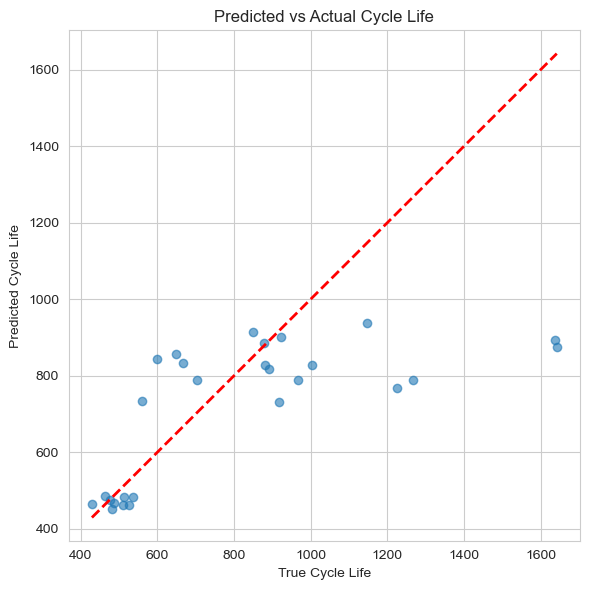


🌀 Run 1
📥 Loading existing weights...


C:\Users\ROHIT\miniconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.
📉 Best val loss this run: 0.348773
⏩ No improvement. Count increased.

🌀 Run 2
📥 Loading existing weights...

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 3.
📉 Best val loss this run: 0.357372
⏩ No improvement. Count increased.

🌀 Run 3
📥 Loading existing weights...

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
📉 Best val loss this run: 0.359988
⏩ No improvement. Count increa

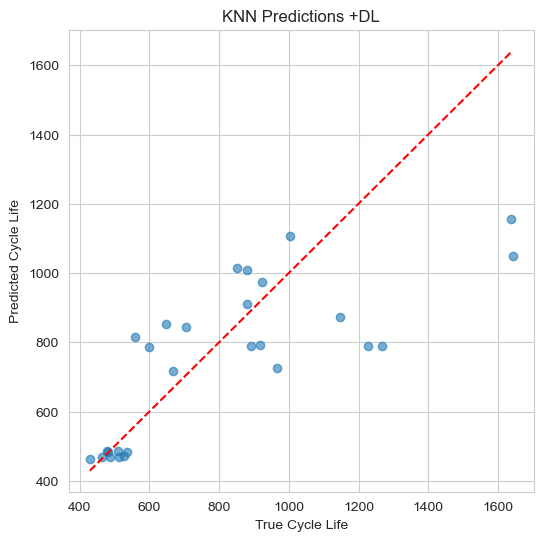

XGB +DL
MAE  : 154.0 cycles
RMSE : 240.5 cycles
R²   : 0.490
APE  : 16.4%


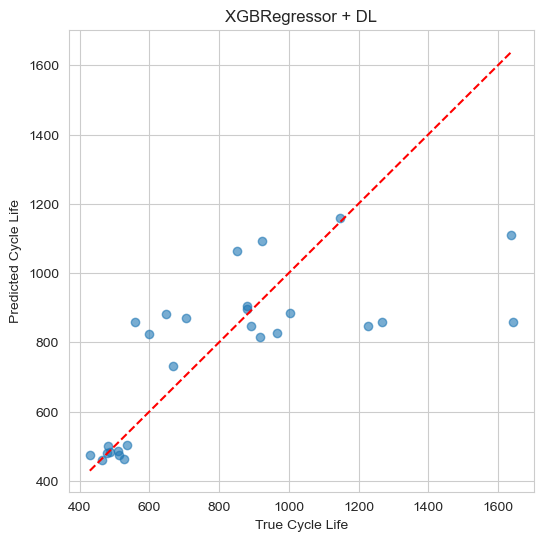

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2300
[LightGBM] [Info] Number of data points in the train set: 104, number of used features: 84
[LightGBM] [Info] Start training from score 0.500187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\ROHIT\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


📊 LGBM + DL Evaluation
MAE  : 159.5 cycles
RMSE : 246.3 cycles
R²   : 0.465
APE  : 17.3%


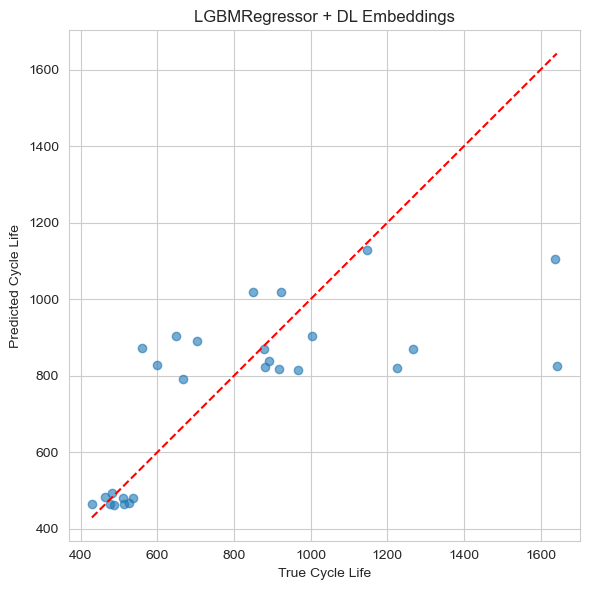

In [38]:
import pandas as pd

# 1️⃣ Count cycles per battery
battery_counts = df_cleaned['battery_id'].value_counts()

# 2️⃣ Keep only batteries with at least 50 cycles
valid_batteries = battery_counts[battery_counts >= 20].index
df_filtered = df_cleaned[df_cleaned['battery_id'].isin(valid_batteries)]

# 3️⃣ Sort and keep only first 50 cycles per battery
df_50_cycles = (
    df_filtered.sort_values(['battery_id', 'cycle'])
    .groupby('battery_id')
    .head(10)
    .reset_index(drop=True)
)

# ✅ Result summary
print("Final shape:", df_50_cycles.shape)
print("Unique batteries:", df_50_cycles['battery_id'].nunique())

from sklearn.impute import KNNImputer
import pandas as pd

# Define columns to impute
cols_to_impute = ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime','C1','Q1','C2','cycle_life']

# Create imputer instance
imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Fit and transform only those columns, preserving the rest
df_imputed = df_50_cycles.copy()
df_imputed[cols_to_impute] = imputer.fit_transform(df_imputed[cols_to_impute])

# Confirm success
print("✅ Imputation complete. Any NAs remaining?",
      df_imputed[cols_to_impute].isna().any().any())

df_50_cycles=df_imputed.copy()

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis

# 0. Start with df_50_cycles: rows = cycles 1–50 for each battery_id
# Aggregation: create per-battery features
from scipy.stats import skew, kurtosis

def aggregate_with_dqv_hist(df, cycle_a=10, cycle_b=100,
                            voltage_grid=np.linspace(2.5, 4.0, 50),
                            bins=5):
    def delta_qv_features(grp):
        a = grp[grp['cycle'] == cycle_a]
        b = grp[grp['cycle'] == cycle_b]
        # ensure both cycles exist
        if a.empty or b.empty:
            return {'dqv_mean': np.nan, 'dqv_var': np.nan,
                    'dqv_skew': np.nan, 'dqv_kurtosis': np.nan}
        qa = np.interp(voltage_grid, a['Q1'], a['QC'])
        qb = np.interp(voltage_grid, b['Q1'], b['QC'])
        dq = qb - qa
        return {
            'dqv_mean': np.nanmean(dq),
            'dqv_var': np.nanvar(dq),
            'dqv_skew': skew(dq),
            'dqv_kurtosis': kurtosis(dq)
        }

    def hist_features(grp, col, bins):
        vals = grp[col].dropna()
        hist, _ = np.histogram(vals, bins=bins, density=True)
        return {f'{col}_hist_{i}': hist[i] for i in range(len(hist))}

    agg_rows = []
    for bid, grp in df.groupby('battery_id'):
        d = {}
        # existing stats & trends
        for col in ['IR', 'QC', 'QD', 'Tavg']:
            vals = grp[col]
            d[f'{col}_mean'] = vals.mean()
            d[f'{col}_std']  = vals.std()
            d[f'{col}_min']  = vals.min()
            d[f'{col}_max']  = vals.max()
            d[f'{col}_skew'] = skew(vals)
            d[f'{col}_kurtosis'] = kurtosis(vals)
            d[f'{col}_trend'] = np.polyfit(grp['cycle'], vals, 1)[0]

        # add ΔQ/ΔV features
        d.update(delta_qv_features(grp))

        # add histograms
        d.update(hist_features(grp, 'IR', bins))
        d.update(hist_features(grp, 'Tavg', bins))

        d['cycle_life'] = grp['cycle_life'].iloc[0]
        agg_rows.append((bid, d))



    agg = pd.DataFrame.from_dict({bid: d for bid, d in agg_rows}, orient='index')
    return agg




agg = aggregate_with_dqv_hist(df_50_cycles)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
# Now your data is per battery: rows = battery_ids

iter_imp = IterativeImputer(random_state=42)

X = agg.drop(columns=['cycle_life'])
X = iter_imp.fit_transform(X)
y = agg['cycle_life']

# ✅ 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ✅ 2. Apply QT separately
qt_X = QuantileTransformer(output_distribution='uniform', random_state=42)
X_train_q = qt_X.fit_transform(X_train)
X_test_q = qt_X.transform(X_test)

qt_y = QuantileTransformer(output_distribution='uniform', random_state=42)
y_train_q = qt_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_q = qt_y.transform(y_test.values.reshape(-1, 1)).flatten()

import joblib

joblib.dump(qt_X, "qt_X_transformer.pkl")
joblib.dump(qt_y, "qt_y_transformer.pkl")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
import numpy as np

# 1. Base Regression Model (Quantile-Transformed inputs)
modelX = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
modelX.fit(X_train_q, y_train_q)
y_pred_q = modelX.predict(X_test_q)

# 2. Center and apply CIR
y_mean = np.mean(y_train_q)
cir = IsotonicRegression(increasing=True, out_of_bounds='clip')
cir.fit(y_train_q - y_mean, y_train_q)
y_pred_q_cir = cir.predict(y_pred_q - y_mean)

# 3. Inverse-transform back to original scale
y_pred_final = qt_y.inverse_transform(y_pred_q_cir.reshape(-1, 1)).flatten()

# 4. Absolute true values
y_true = y_test.values  # numpy array

# 5. Metrics
mae = mean_absolute_error(y_true, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_final))
r2 = r2_score(y_true, y_pred_final)
XGB_RAW_ape = np.mean(np.abs((y_true - y_pred_final) / y_true)) * 100

print("✅ QT + CIR Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {XGB_RAW_ape:.1f}%")
all_apes.append(f"XGB_10_APE  : {XGB_RAW_ape:.1f}%")

# 6. Visualization: Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_final, alpha=0.6)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("XGB Predicted vs Actual Cycle Life")
plt.grid(True)
plt.show()


from lightgbm import LGBMRegressor
lgb = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

modelL = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
modelL.fit(X_train_q, y_train_q)
y_pred_q = modelL.predict(X_test_q)

# 2. Center and apply CIR
y_mean = np.mean(y_train_q)
cir = IsotonicRegression(increasing=True, out_of_bounds='clip')
cir.fit(y_train_q - y_mean, y_train_q)
y_pred_q_cir = cir.predict(y_pred_q - y_mean)

# 3. Inverse-transform back to original scale
y_pred_final = qt_y.inverse_transform(y_pred_q_cir.reshape(-1, 1)).flatten()

# 4. Absolute true values
y_true = y_test.values  # numpy array

# 5. Metrics
mae = mean_absolute_error(y_true, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_true, y_pred_final))
r2 = r2_score(y_true, y_pred_final)
LGBM_RAW_ape = np.mean(np.abs((y_true - y_pred_final) / y_true)) * 100

print("✅ QT + CIR Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {LGBM_RAW_ape:.1f}%")
all_apes.append(f"LGBM_10_APE  : {LGBM_RAW_ape:.1f}%")

# 6. Visualization: Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_final, alpha=0.6)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("Predicted vs Actual Cycle Life")
plt.grid(True)
plt.show()
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np


# 3. Train DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train_q, y_train_q)
y_pred_q = tree.predict(X_test_q)

# 4. (Optional) Apply CIR for monotonic correction
y_mean = np.mean(y_train_q)
cir = IsotonicRegression(increasing=True, out_of_bounds='clip')
cir.fit(y_train_q - y_mean, y_train_q)
y_pred_q_cir = cir.predict(y_pred_q - y_mean)

# 5. Inverse-transform predictions
# Skip CIR if you don't want it: use y_pred_q directly
y_pred_final = qt_y.inverse_transform(y_pred_q_cir.reshape(-1, 1)).flatten()

# 6. Evaluate performance
mae = mean_absolute_error(y_test, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2 = r2_score(y_test, y_pred_final)
DECISION_TREE_RAW_APE= np.mean(np.abs((y_true - y_pred_final) / y_true)) * 100

print("✅ QT + CIR Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"DECISION_TREE_RAW_APE  : {DECISION_TREE_RAW_APE:.1f}%")
all_apes.append(f"DECISION_TREE_10_APE  : {DECISION_TREE_RAW_APE:.1f}%")

# 6. Visualization: Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred_final, alpha=0.6)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("Predicted vs Actual Cycle Life")
plt.grid(True)
plt.show()
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Assume X_train_q, X_test_q, y_train, y_test, qt_y defined already

# 1️⃣ Train KNN regressor
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(X_train_q, y_train_q)

# 2️⃣ Prediction
y_pred_q = knn.predict(X_test_q)

# 3️⃣ Inverse-transform predictions
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()

# 4️⃣ Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
KNN_RAW_APE= np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("🤝 KNN Regression + QT:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {KNN_RAW_APE:.1f}%")
all_apes.append(f"KNN_10_APE : {DECISION_TREE_RAW_APE:.1f}%")
# 5️⃣ Visualization
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("KNN Predictions (QT-transformed)")
plt.grid(True)
plt.show()
import pandas as pd
import numpy as np

# Step 1: Prepare original feature columns
original_cols = agg.drop(columns=['cycle_life']).columns.tolist()

# Step 2: Drop target and apply IterativeImputer
X = agg.drop(columns=['cycle_life'])
X_imputed = iter_imp.fit_transform(X)

# Step 3: Handle dropped columns gracefully
# Only keep columns that did NOT become all-NaN or caused failure in IterativeImputer
retained_col_count = X_imputed.shape[1]

# Step 4: Identify which columns were dropped
retained_cols = original_cols[:retained_col_count]  # safe assumption: IterativeImputer returns in order but drops tailing NaN cols
dropped_cols = list(set(original_cols) - set(retained_cols))

# Step 5: Print
print(f"✅ Retained ({len(retained_cols)}):", retained_cols)
print(f"❌ Dropped ({len(dropped_cols)}):", dropped_cols)

# Step 6: Proceed with retained_cols for further work
X_imputed_df = pd.DataFrame(X_imputed, columns=retained_cols)
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

MODEL_PATH = "best_model_10.keras"

# 1. If model exists, load it
if os.path.exists(MODEL_PATH):
    print(f"🔁 Loading existing model from {MODEL_PATH}")
    model = load_model(MODEL_PATH)
else:
    print("🛠️ Building new model...")
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(1e-5), input_shape=(X_train_q.shape[1],)),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=l2(1e-5)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

# 2. Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

model_ckpt = ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,  # Saves full model
    verbose=1
)

# 3. Train model
history = model.fit(
    X_train_q, y_train_q,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, reduce_lr, model_ckpt],
    verbose=1
)
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1️⃣ Load saved model
model = load_model("best_model_10.keras")

# 2️⃣ Predict
y_pred_q = model.predict(X_test_q).flatten()

# 3️⃣ Inverse transform if target was scaled
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()

# 4️⃣ True values (inverse transform if needed)
y_true = y_test  # or: qt_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 5️⃣ Evaluation
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
DL_RAW_APE= np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("✅ QT + CIR Evaluation:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {DL_RAW_APE:.1f}%")
all_apes.append(f"DL_10_APE : {DL_RAW_APE:.1f}%")
# 6️⃣ Visualization
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
         'r--', linewidth=2)
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("Predicted vs Actual Cycle Life")
plt.grid(True)
plt.tight_layout()
plt.show()
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ------------------------
# Set Global Seed Once
# ------------------------


# ------------------------
# Define Model Architecture
# ------------------------
def build_model(input_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(256, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu', name='embedding_layer')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# ------------------------
# Paths
# ------------------------
model_weights_path = "best_dl10.weights.h5"
val_loss_record_path = "best_val_loss10.txt"

# ------------------------
# Normalize y_train_q
# ------------------------
y_mean = y_train_q.mean()
y_std = y_train_q.std()
y_train_scaled = (y_train_q - y_mean) / y_std

# ------------------------
# Initial Setup
# ------------------------
first_time = not os.path.exists(model_weights_path)

if os.path.exists(val_loss_record_path):
    with open(val_loss_record_path, "r") as f:
        best_val_loss = float(f.read().strip())
else:
    best_val_loss = float('inf')

# ------------------------
# Train Loop with EarlyStopping
# ------------------------
count = 0
for i in range(100):
    np.random.seed(i)
    tf.random.set_seed(i)
    if count >= 10:
        break

    print(f"\n🌀 Run {i+1}")

    # Build model
    base_model = build_model(X_train_q.shape[1])

    # Load previous weights if available
    if not first_time and os.path.exists(model_weights_path):
        print("📥 Loading existing weights...")
        base_model.load_weights(model_weights_path)

    # Train model
    history = base_model.fit(
        X_train_q, y_train_scaled,
        validation_split=0.2,
        epochs=100,
        batch_size=16,
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
        ],
        verbose=0
    )

    # Get best val loss this run
    run_best_val_loss = min(history.history['val_loss'])
    print(f"📉 Best val loss this run: {run_best_val_loss:.6f}")

    # Save first model no matter what
    if first_time:
        print(f"💾 Saving initial weights with val_loss: {run_best_val_loss:.6f}")
        base_model.save_weights(model_weights_path)
        with open(val_loss_record_path, "w") as f:
            f.write(str(run_best_val_loss))
        best_val_loss = run_best_val_loss
        first_time = False
        count = 0
    elif run_best_val_loss < best_val_loss - 1e-6:
        print(f"✅ Improved: {best_val_loss:.6f} → {run_best_val_loss:.6f} — saving weights.")
        base_model.save_weights(model_weights_path)
        with open(val_loss_record_path, "w") as f:
            f.write(str(run_best_val_loss))
        best_val_loss = run_best_val_loss
        count = 0
    else:
        print("⏩ No improvement. Count increased.")
        count += 1

# ------------------------
# Load Best Model & Extract Embeddings
# ------------------------
base_model = build_model(X_train_q.shape[1])
base_model.load_weights(model_weights_path)

embed_model = Model(
    inputs=base_model.input,
    outputs=base_model.get_layer('embedding_layer').output
)
X_train_embed = embed_model.predict(X_train_q)
X_test_embed = embed_model.predict(X_test_q)

# Optional: Predict and unscale
y_pred_scaled = base_model.predict(X_test_q)
y_pred = y_pred_scaled * y_std + y_mean
# Step 4: Train KNN on these embeddings
knnDL = KNeighborsRegressor(n_neighbors=3)
knnDL.fit(X_train_embed, y_train_q)
y_pred_q = knnDL.predict(X_test_embed)

# Step 5: Inverse transform and evaluate
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
KNN__DL_RAW_APE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("🤝KNN + DL:")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {KNN__DL_RAW_APE:.1f}%")
all_apes.append(f"KNN__DL_10_APE : {KNN__DL_RAW_APE:.1f}%")
# 5️⃣ Visualization
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("KNN Predictions +DL")
plt.grid(True)
plt.show()
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 4: Train XGBoost on DL embeddings
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

X_train_combined = np.concatenate([X_train_q, X_train_embed], axis=1)
X_test_combined = np.concatenate([X_test_q, X_test_embed], axis=1)

xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
xgb.fit(X_train_combined, y_train_q)

y_pred_q = xgb.predict(X_test_combined)
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()


# Step 6: Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
XGB__DL_RAW_APE= np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("XGB +DL")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {XGB__DL_RAW_APE:.1f}%")
all_apes.append(f"XGB__DL_10_APE : {XGB__DL_RAW_APE:.1f}%")
# 5️⃣ Visualization
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("XGBRegressor + DL")
plt.grid(True)
plt.show()
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Combine features: handcrafted + DL embeddings
X_train_combined = np.concatenate([X_train_q, X_train_embed], axis=1)
X_test_combined = np.concatenate([X_test_q, X_test_embed], axis=1)

# Initialize and train LGBM model
lgbm = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    objective='regression'
)
lgbm.fit(X_train_combined, y_train_q)

# Predict and inverse-transform
y_pred_q = lgbm.predict(X_test_combined)
y_pred = qt_y.inverse_transform(y_pred_q.reshape(-1, 1)).flatten()

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
LGBM__DL_RAW_APE= np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("📊 LGBM + DL Evaluation")
print(f"MAE  : {mae:.1f} cycles")
print(f"RMSE : {rmse:.1f} cycles")
print(f"R²   : {r2:.3f}")
print(f"APE  : {LGBM__DL_RAW_APE:.1f}%")
all_apes.append(f"LGBM__DL_10_APE : {LGBM__DL_RAW_APE:.1f}%")
# Plot: Predicted vs True
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("LGBMRegressor + DL Embeddings")
plt.grid(True)
plt.tight_layout()
plt.show()

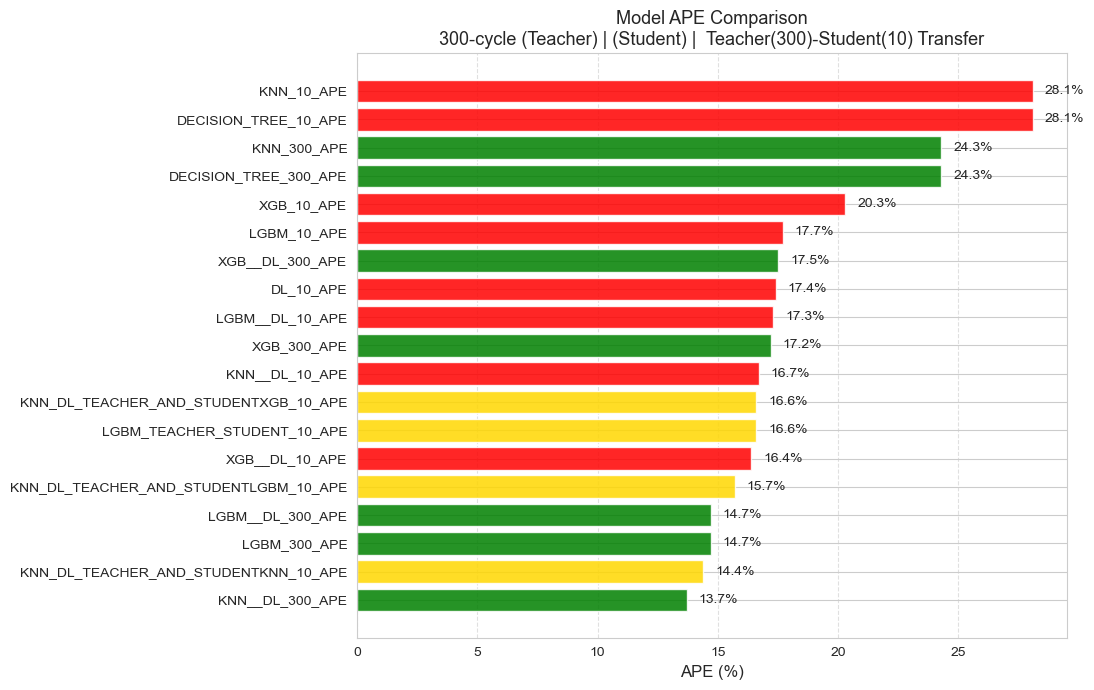

In [39]:
import matplotlib.pyplot as plt

# Parse and classify
labels, values, colors = [], [], []

for entry in all_apes:
    name, val = entry.split(':')
    name = name.strip()
    ape_val = float(val.strip().replace('%', ''))

    labels.append(name)
    values.append(ape_val)

    tag = name.upper()

    # Classification logic
    if tag.endswith("300_APE") or "__DL_300_APE" in tag:
        colors.append("green")  # 🟢 Teacher (300-cycle)
    elif "TEACHER_STUDENT_10_APE" in tag or "TEACHER_AND_STUDENT" in tag:
        colors.append("gold")   # 🟡 Teacher-Student
    elif tag.endswith("10_APE"):
        colors.append("red")    # 🔴 Raw Student (10-cycle only)
    else:
        colors.append("gray")
        # Sort by APE value
sorted_data = sorted(zip(labels, values, colors), key=lambda x: x[1])
labels, values, colors = zip(*sorted_data)

# Plot
plt.figure(figsize=(11, 7))
bars = plt.barh(labels, values, color=colors, alpha=0.85)

plt.xlabel("APE (%)", fontsize=12)
plt.title("Model APE Comparison\n300-cycle (Teacher) | (Student) |  Teacher(300)-Student(10) Transfer", fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f"{width:.1f}%", va='center', fontsize=10)

plt.tight_layout()
plt.show()